# 05. PyTorch Going Modular Exercises

Welcome to the 05. PyTorch Going Modular exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ijgFhMK3pp4).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/05_pytorch_going_modular_exercise_solutions.ipynb).

## 1. Turn the code to get the data (from section 1. Get Data) into a Python script, such as `get_data.py`.

* When you run the script using `python get_data.py` it should check if the data already exists and skip downloading if it does.
* If the data download is successful, you should be able to access the `pizza_steak_sushi` images from the `data` directory.

In [1]:
%%writefile get_data.py

import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")


Writing get_data.py


In [2]:
# Example running of get_data.py
!python get_data.py

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Use [Python's `argparse` module](https://docs.python.org/3/library/argparse.html) to be able to send the `train.py` custom hyperparameter values for training procedures.
* Add an argument flag for using a different:
  * Training/testing directory
  * Learning rate
  * Batch size
  * Number of epochs to train for
  * Number of hidden units in the TinyVGG model
    * Keep the default values for each of the above arguments as what they already are (as in notebook 05).
* For example, you should be able to run something similar to the following line to train a TinyVGG model with a learning rate of 0.003 and a batch size of 64 for 20 epochs: `python train.py --learning_rate 0.003 batch_size 64 num_epochs 20`.
* **Note:** Since `train.py` leverages the other scripts we created in section 05, such as, `model_builder.py`, `utils.py` and `engine.py`, you'll have to make sure they're available to use too. You can find these in the [`going_modular` folder on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular).

In [3]:
# YOUR CODE HERE
%%writefile test.py
import argparse

# Step 1: Create ArgumentParser object
parser = argparse.ArgumentParser(description="A simple program to greet users")

# Step 2: Add arguments
parser.add_argument("name", type=str, help="Name of the user")  # Positional argument
parser.add_argument("--age", type=int, help="Age of the user", required=False)  # Optional argument

# Step 3: Parse arguments from the command line
args = parser.parse_args()

# Step 4: Access the arguments
print(f"Hello, {args.name}!")
if args.age:
    print(f"You are {args.age} years old.")

Writing test.py


In [4]:
!python test.py afnan --age 10

Hello, afnan!
You are 10 years old.


In [28]:
%%writefile train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
import data_setup, engine, model_builder, utils
import argparse

from torchvision import transforms

# Setup parser
parser = argparse.ArgumentParser(
                    prog='train.py'
                    )

parser.add_argument("--train_dir", type=str, help="Training directory", required=False, default="data/pizza_steak_sushi/train")
parser.add_argument("--test_dir", type=str, help="Testing directory", required=False, default="data/pizza_steak_sushi/test")

parser.add_argument("--learning_rate", type=float, help="Learning rate", required=False, default=0.001)
parser.add_argument("--batch_size", type=int, help="Batch size", required=False, default=32)
parser.add_argument("--num_epochs", type=int, help="Number of epochs", required=False, default=5)
parser.add_argument("--hidden_units", type=int, help="Number of hidden units", required=False, default=10)

args = parser.parse_args()

NUM_EPOCHS = args.num_epochs
BATCH_SIZE = args.batch_size
HIDDEN_UNITS = args.hidden_units
LEARNING_RATE = args.learning_rate

train_dir = args.train_dir
test_dir = args.test_dir

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

Overwriting train.py


In [29]:
# Example running of train.py
!python train.py --num_epochs 5 --batch_size 128 --hidden_units 128 --learning_rate 0.0003

  0% 0/5 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.1087 | train_acc: 0.3162 | test_loss: 1.0949 | test_acc: 0.3333
 20% 1/5 [00:01<00:06,  1.51s/it]Epoch: 2 | train_loss: 1.0944 | train_acc: 0.3421 | test_loss: 1.0982 | test_acc: 0.3867
 40% 2/5 [00:02<00:03,  1.27s/it]Epoch: 3 | train_loss: 1.0860 | train_acc: 0.4932 | test_loss: 1.0883 | test_acc: 0.4133
 60% 3/5 [00:03<00:02,  1.25s/it]Epoch: 4 | train_loss: 1.0685 | train_acc: 0.4729 | test_loss: 1.0741 | test_acc: 0.4533
 80% 4/5 [00:05<00:01,  1.24s/it]Epoch: 5 | train_loss: 1.0386 | train_acc: 0.5218 | test_loss: 1.0442 | test_acc: 0.4000
100% 5/5 [00:06<00:00,  1.25s/it]
[INFO] Saving model to: models/05_going_modular_script_mode_tinyvgg_model.pth


## 3. Create a Python script to predict (such as `predict.py`) on a target image given a file path with a saved model.

* For example, you should be able to run the command `python predict.py some_image.jpeg` and have a trained PyTorch model predict on the image and return its prediction.
* To see example prediction code, check out the [predicting on a custom image section in notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function).
* You may also have to write code to load in a trained model.

In [38]:
%matplotlib inline

In [45]:
# YOUR CODE HERE
%%writefile predict.py
"""
predict a target image class given a file path with a saved model
"""
import argparse
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

import model_builder

#hardcoded class names
class_names = ['pizza', 'steak', 'sushi']

# Setup parser
parser = argparse.ArgumentParser(
                    prog='predict.py'
                  )

parser.add_argument("--image", type=str, help="Image path",required=True)

args = parser.parse_args()

# Load the model
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=128,
    output_shape=3
)

model.load_state_dict(torch.load("models/05_going_modular_script_mode_tinyvgg_model.pth", weights_only=True))

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load in image and convert the tensor values to float32
target_image = torchvision.io.read_image(str(args.image)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
target_image = target_image / 255.

# Transform image
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.ToTensor(),
])

target_image = transform(target_image)

# Make sure the model is on the target device
model.to(device)

# Turn on model evaluation mode and inference mode
model.eval()
with torch.inference_mode():
    # Add an extra dimension to the image
    target_image = target_image.unsqueeze(dim=0)

    # Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(target_image.to(device))

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

# Convert prediction probabilities -> prediction labels
target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

# Plot the image alongside the prediction and prediction probability
plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
plt.title(title)
plt.axis(False)

plt.savefig("output_image.png")  # Save the figure

Overwriting predict.py


In [46]:
# Example running of predict.py
!python predict.py --image data/pizza_steak_sushi/test/sushi/175783.jpg

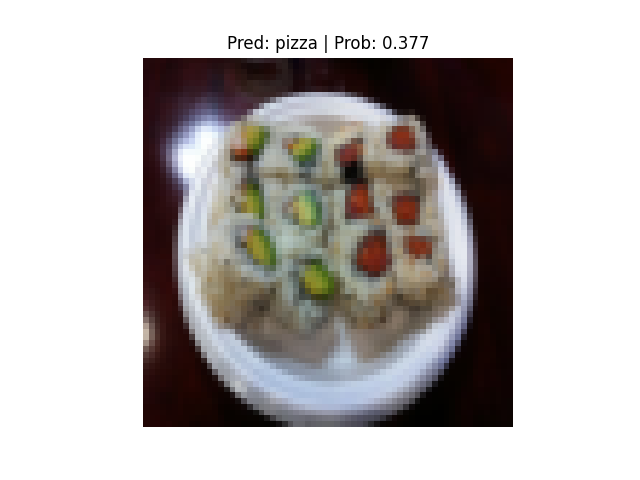

In [47]:
from IPython.display import Image, display
display(Image(filename="output_image.png"))
